# 3 Exploratory Data Analysis

## Table of Contents:

* [3.1 Introduction](#3.1)
* [3.2 Import Packages](#3.2)
* [3.3 Load the Data](#3.3)
* [3.4 Exploring the Data](#3.4)
  * [3.4.1 Correlation Heatmap](#3.4.1)
  * [3.4.2 Histograms and Boxplots](#3.4.2)
  * [3.4.3 T-Test](#3.4.3)
* [3.5 Dimensionality Reduction](#3.5)
  * [3.5.1 Scaling the Data](#3.5.1)
  * [3.5.2 PCA and Scree Plots](#3.5.2)
  * [3.5.3 Visualizing with t-SNE](#3.5.3)
      * [3.5.3.1 K-Means Clustering](#3.5.3.1)
* [3.6 Summary and Next Steps](#3.6)


## 3.1 Introduction<a id='3.1'></a>

In our previous notebook, "Step 2 - Data Wrangling", we learned that only 3.23% of our dataset are of bankrupt companies, a small minority class. To address this, we should consider various methods of upsampling our minority class (such as SMOTE (Synthetic Minority Oversampling TEchnique) and its extensions). But before we can use a method like SMOTE, we need to confirm that our dataset has good separation between its classes. 

One method we can use is Principal Component Analysis, or PCA. PCA is useful for dimensionality reduction, which can improve the performance of our model by removing redundant features. In our previous notebook, we removed the column "Net Income Flag", since it had the same value (1) for every row, and thus did not add any information to the bankruptcy dataset. This left us with 95 features. We should reduce this down to the most essential components, i.e. the components that explain 85%-95% of the variance in the dataset. 

This reduced set of dimensions can then be further visualized using t-distributed Stochastic Neighbor Embedding (t-SNE). t-SNE is a tool to visualize high-dimensional data. It has several advantages over other manifold learning techniques, as it is particularly sensitive to local structure. t-SNE will help us ascertain whether we have obtained good separation between our classes (though poor separation in t-SNE may also indicate that 2 dimensions is insufficient in representing the internal structure of the data).

We can also use K-Means Clustering as a method to label and visualize the clusters in the data. This is an unsupervised learning method, and may be able to show us whether there are underlying similarities in the types of companies. In combination with t-SNE, we may be able to identify patterns in the data and see wether bankrupt companies predominantly fall under a given cluster label.

Previously we also inspected potential outliers in 18 features. Since so many of the features have highly skewed data, we will for sure want to scale it prior to our PCA. A simple scaling method would be to find the log of each feature, and we could also look into scalers in the sklearn library (e.g. StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer).

__Objective:__ In this notebook, we will do the following:
* Explore the data to learn more about the features by using...
    * correlation heatmap to image feature relationships, 
    * histograms and boxplots to image the distribution of feature samples, 
    * and t-tests to determine statistical significance between classes.
* Use PCA and t-SNE for dimensionality reduction and visualization.
    * Scale the data.
    * Fit the PCA transformation and apply to the data to create derived features.
    * Use a scree plot to reduce the dimensionality of our data.
    * Fit the t-SNE transformation and apply to the data.
    * Use K-Means Clustering to label and visualize clusters on the t-SNE plot.

## 3.2 Import Packages<a id='3.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import timeit
import time
from scipy.stats import skew, kurtosis, ttest_ind

## 3.3 Load the Data<a id='3.3'></a>

In [2]:
df = pd.read_csv('data_wrangled.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490


In [3]:
#Check that we have 6819 instances and 95 features.
df.shape

(6819, 95)

In [4]:
#Check the datatypes of each feature.
df.info()

# We can see that only 'Bankrupt?' and 'Liability-Assets Flag' are ints while everything else are floats. 
# This means that aside from our target variable (i.e. whether a company goes bankrupt or not) and 1 feature, 
# the rest of the features are continuous variables. We can therefore evaluate relationships via correlation heatmaps
# and check their distribution via histograms.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

## 3.4 Exploring the Data<a id='3.4'></a>

Before we dive into dimensionality reduction, we should first understand the relationships between our features and classes. Many of our features are continuous variables, allowing us to do some quantitative analyses. In this section, we will visualize the relationship between features using a correlation heatmap. We will look at the distributions using histograms. And we will run t-tests on all of the quantitative features to establish whether there is a statistically significant difference between features of one class (bankrupt companies) versus that of the other class (non-bankrupt companies).

### 3.4.1 Correlation Heatmap<a id='3.4.1'></a>

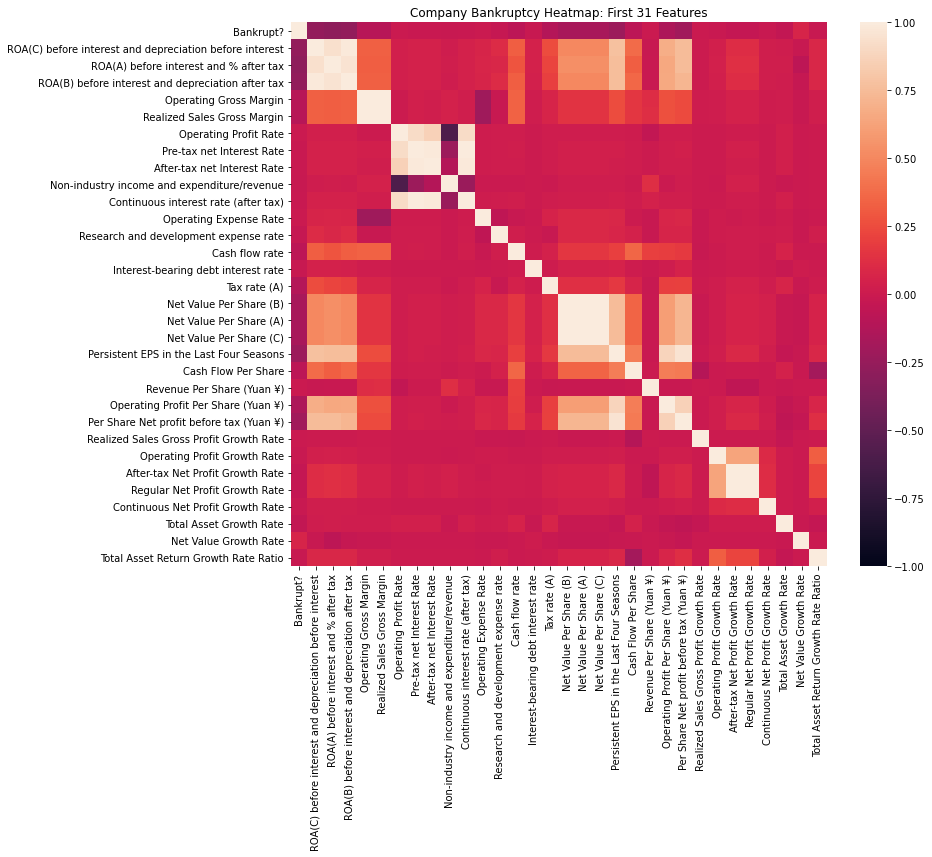

In [5]:
#Since we have a large number of features, we split them apart into 3 separate visualizations.
plt.subplots(figsize=(12,10))
plt.title('Company Bankruptcy Heatmap: First 31 Features')
sns.heatmap(df.iloc[:,:32].corr(), vmin = -1, vmax = 1);

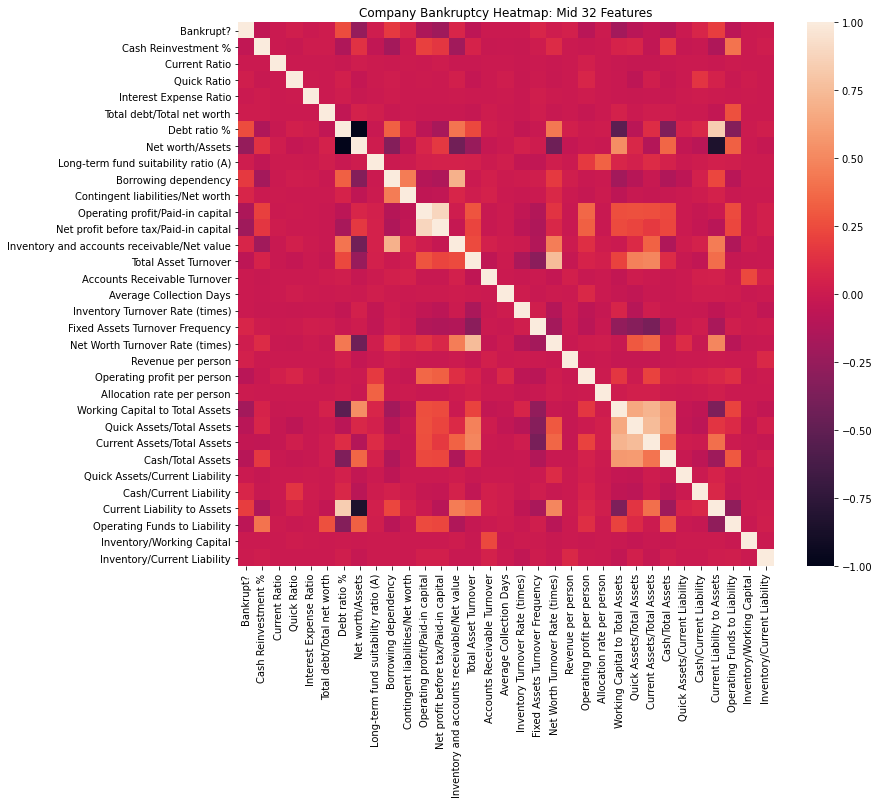

In [6]:
plt.subplots(figsize=(12,10))
plt.title('Company Bankruptcy Heatmap: Mid 32 Features')
mid = pd.concat([df[['Bankrupt?']], df.iloc[:,32:64]], axis=1) #make sure to keep target variable 'Bankrupt?'
sns.heatmap(mid.corr(), vmin = -1, vmax = 1);

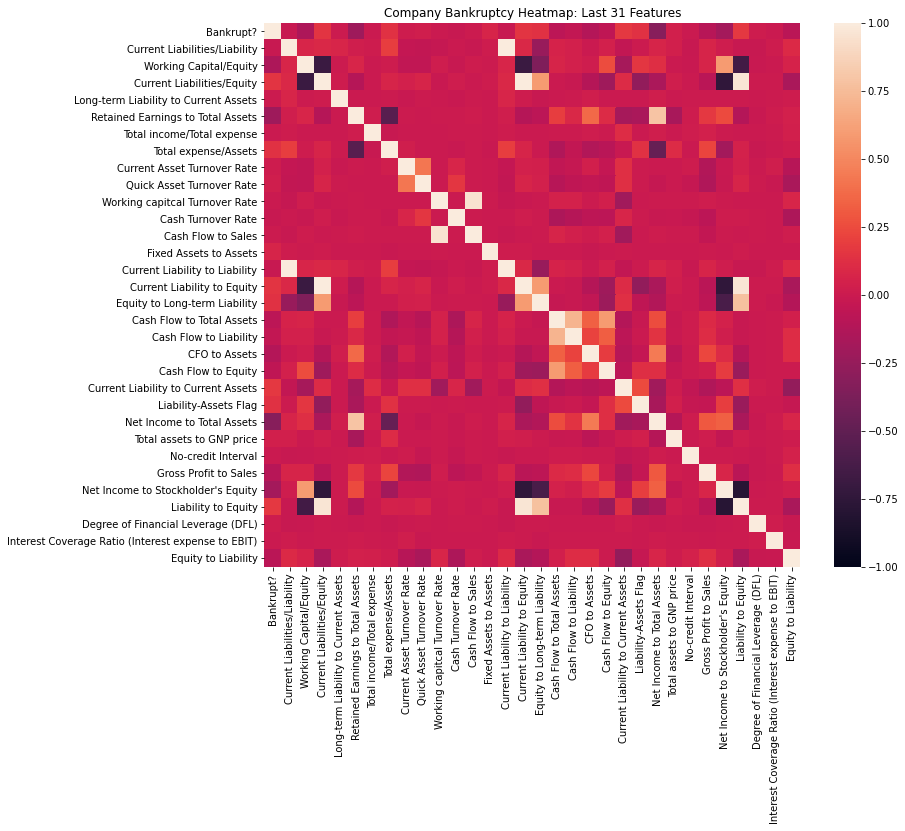

In [7]:
plt.subplots(figsize=(12,10))
plt.title('Company Bankruptcy Heatmap: Last 31 Features')
last = pd.concat([df[['Bankrupt?']], df.iloc[:,64:]], axis=1) #make sure to keep target variable 'Bankrupt?'
sns.heatmap(last.corr(), vmin = -1, vmax = 1);

From the three correlation heatmaps, we can see correlations between bankruptcy status ('Bankrupt?') and the other 94 features. While there is no feature with a particularly strong positive correlation to bankruptcy, we do see that 'Debt ratio %' and 'Current Liability to Assets' both have a slight positive correlation with bankruptcy. This makes sense, as companies with larger debts and more liabilities than assets are also more likely to go bankrupt.

We do see several features with slight negative correlations with bankruptcy status. 
* In the first graph, bankruptcy has a negative correlation with 
    * the first three 'ROA (Return on Assets)' features, 
    * 'Persistent EPS (earnings per share) in the Last Four Seasons', and 
    * 'Per Share Net profit before tax (Yuan ¥)'. 
* In the second graph, we similarly see a slight negative correlation between bankruptcy and 
    * 'Net worth/Assets', 
    * 'Net profit before tax/Paid in capital', and 
    * 'Working Capital to Total Assets'. 
* In the third graph, again we see a slight negative correlation between bankruptcy and 
    * 'Working Capital/Equity',
    * 'Retained Earnings to Total Assets', 
    * 'Net Income to Total Assets', and
    * 'Net Income to Stockholder's Equity',

This again makes sense, as these features are signs of a healthy company (i.e. less likely to go bankrupt). If a company has good return on assets, that means they are growing as a company. Persistent earnings per share indicates that their stocks are stable/healthy. Large assets and profit again indicates a healthy company.

Setting aside the bankruptcy status, we see that between the other features there are some strong correlations. We see strong positive correlation between the first 3 ROA features. 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', and 'Continuous interest rate (after tax)' all have positive correlations as well. 'Liability to Equity' and 'Working Capital/Equity' have a strong negative correlation. What all these relationships tells us is that not all of these features are independent.

Since many of the features appear to be dependent on each other, we understand that we may be able to obtain significant dimension reduction during the PCA step.

### 3.4.2 Histograms and Boxplots<a id='3.4.2'></a>

A quick and easy way to visualize distributions is through histograms and boxplots. 

Histograms have the benefit of showing us skew and kurtosis of a distribution, but boxplots allow us to easily see the median and interquartile range. The boxplots are an especially nice way to visualize differences in distribution between the majority and minority classes.

In [8]:
# Recall from the previous notebook ('Step 2 - Data Wrangling') we may recall that there were 
# many features with a maximum of 1 and others which had a maximum in the trillions.
# Knowing this, we should visualize these features separately when using df.plot(), since the x-axis will be shared.

describe = df.describe().T
col = describe[(describe['max'] > 1)].index

In [9]:
large_range_features = df[col]
small_range_features = df.drop(columns = col)

print(large_range_features.shape)
print(small_range_features.shape)

(6819, 24)
(6819, 71)


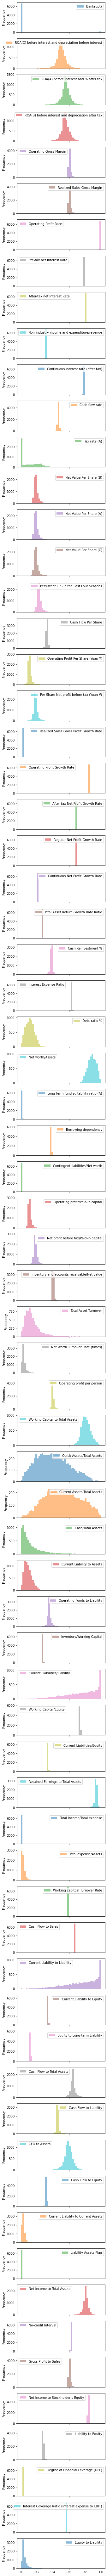

In [10]:
# Plot the distributions/histograms of all of the small-range features
_=small_range_features.plot.hist(bins=50, alpha=0.5, subplots=True, figsize=(5,150))

From the histograms, we see that while many features appear to have a normal distribution, there are others which are highly skewed, such as Tax Rate, Total Asset Turnover, Cash/Total Assets, Current Liability to Assets, Current Liabilities/Liability, Current Liability to Liability, and Equity to Liability. Other features appear to predominantly be in a single bin. We do not see anything that appears bimodal.

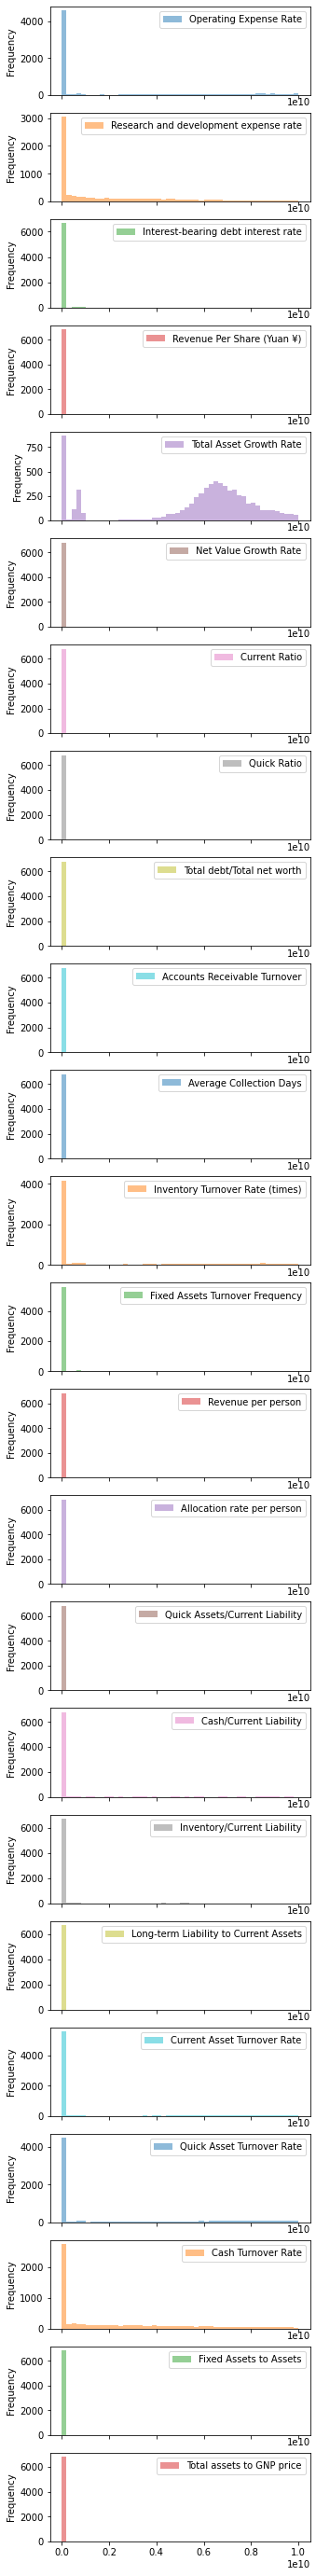

In [11]:
# Plot the distributions/histograms of all of the large-range features
_=large_range_features.plot.hist(bins=50, alpha=0.5, subplots=True, figsize=(5,50))

From these sets of plots, we see that many of these features are highly skewed. We can adjust for this my finding the log of these features.

In [12]:
large_range_features_log1p = np.log1p(large_range_features) #use log1p (ln(1+x)) to avoid log(0) errors

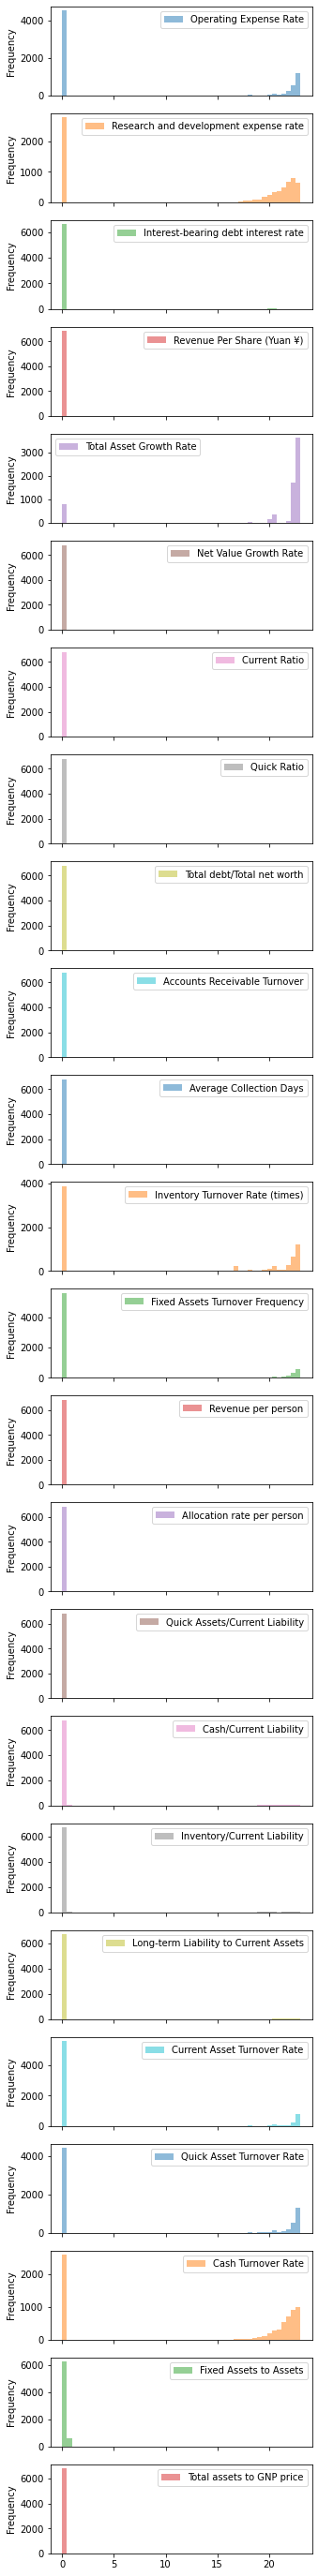

In [13]:
_=large_range_features_log1p.plot.hist(bins=50, alpha=0.5, subplots=True, figsize=(5,50))

This is a little better. We can now see an actual distribution for several of the features. 

In [14]:
small_range_features.shape

(6819, 71)

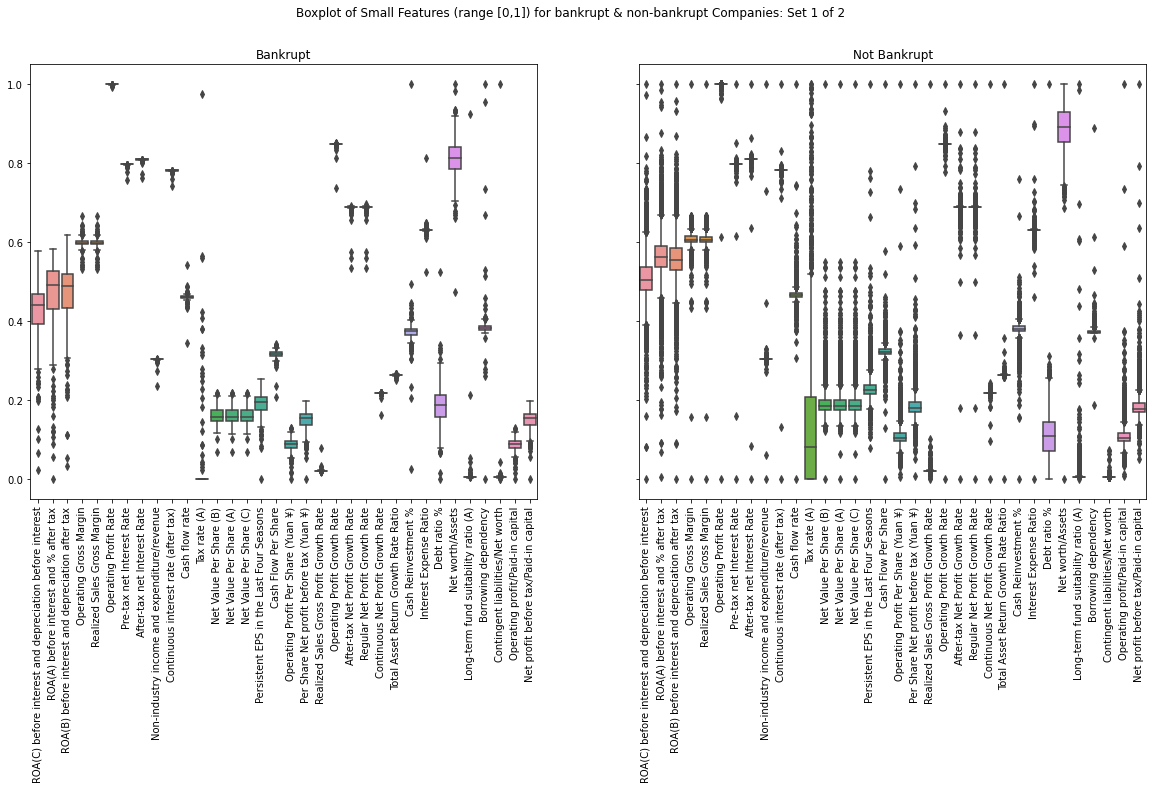

In [15]:
#make boxplot of the small range features
#since we have so many small range features, split them into 3 sets for easier visualization.
boxplot_srf = small_range_features.iloc[:,1:35]
boxplot_srf_bankrupt = boxplot_srf.loc[(small_range_features['Bankrupt?'] == 1)]
boxplot_srf_not_bankrupt = boxplot_srf.loc[small_range_features['Bankrupt?'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Boxplot of Small Features (range [0,1]) for bankrupt & non-bankrupt Companies: Set 1 of 2')

sns.boxplot(ax=axes[0], data = boxplot_srf_bankrupt)
axes[0].set_title('Bankrupt')
axes[0].set_xticklabels(boxplot_srf_bankrupt.columns,rotation=90)

sns.boxplot(ax=axes[1], data = boxplot_srf_not_bankrupt)
axes[1].set_title('Not Bankrupt');
axes[1].set_xticklabels(boxplot_srf_not_bankrupt.columns,rotation=90);


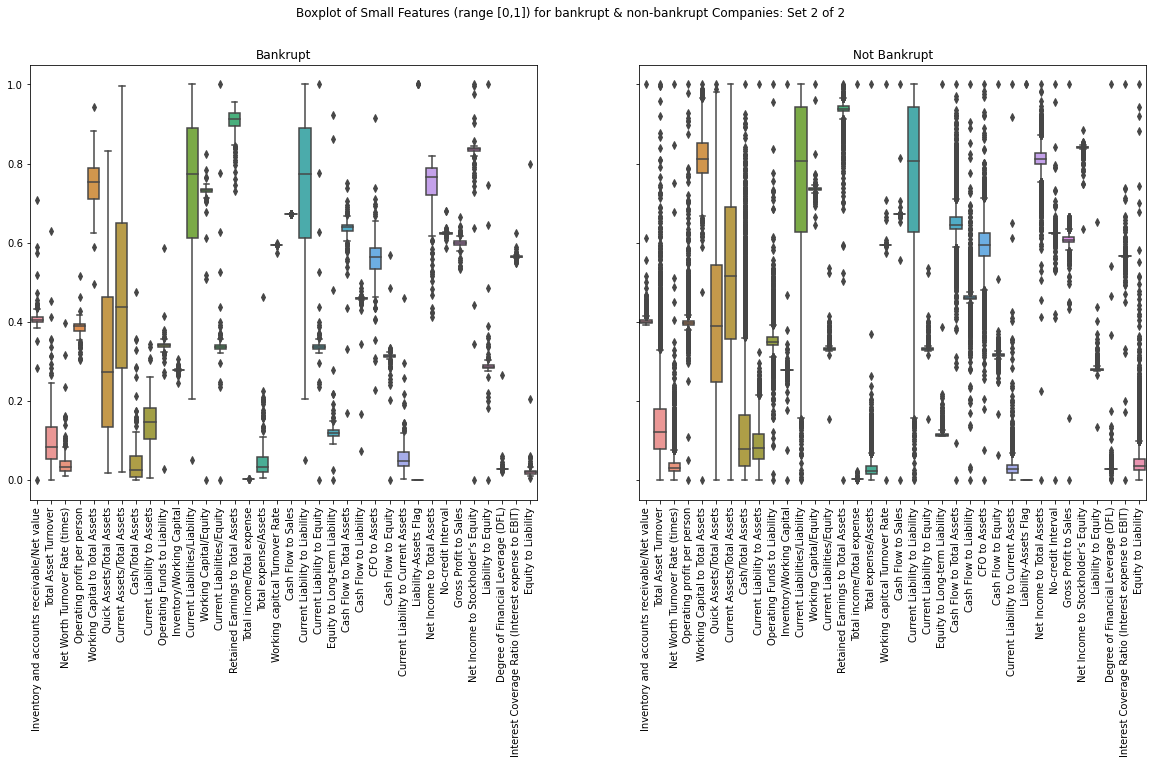

In [16]:
#make boxplot of the small range features
#since we have so many small range features, split them into 3 sets for easier visualization.
boxplot_srf = small_range_features.iloc[:,35:]
boxplot_srf_bankrupt = boxplot_srf.loc[(small_range_features['Bankrupt?'] == 1)]
boxplot_srf_not_bankrupt = boxplot_srf.loc[small_range_features['Bankrupt?'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Boxplot of Small Features (range [0,1]) for bankrupt & non-bankrupt Companies: Set 2 of 2')

sns.boxplot(ax=axes[0], data = boxplot_srf_bankrupt)
axes[0].set_title('Bankrupt')
axes[0].set_xticklabels(boxplot_srf_bankrupt.columns,rotation=90)

sns.boxplot(ax=axes[1], data = boxplot_srf_not_bankrupt)
axes[1].set_title('Not Bankrupt');
axes[1].set_xticklabels(boxplot_srf_not_bankrupt.columns,rotation=90);


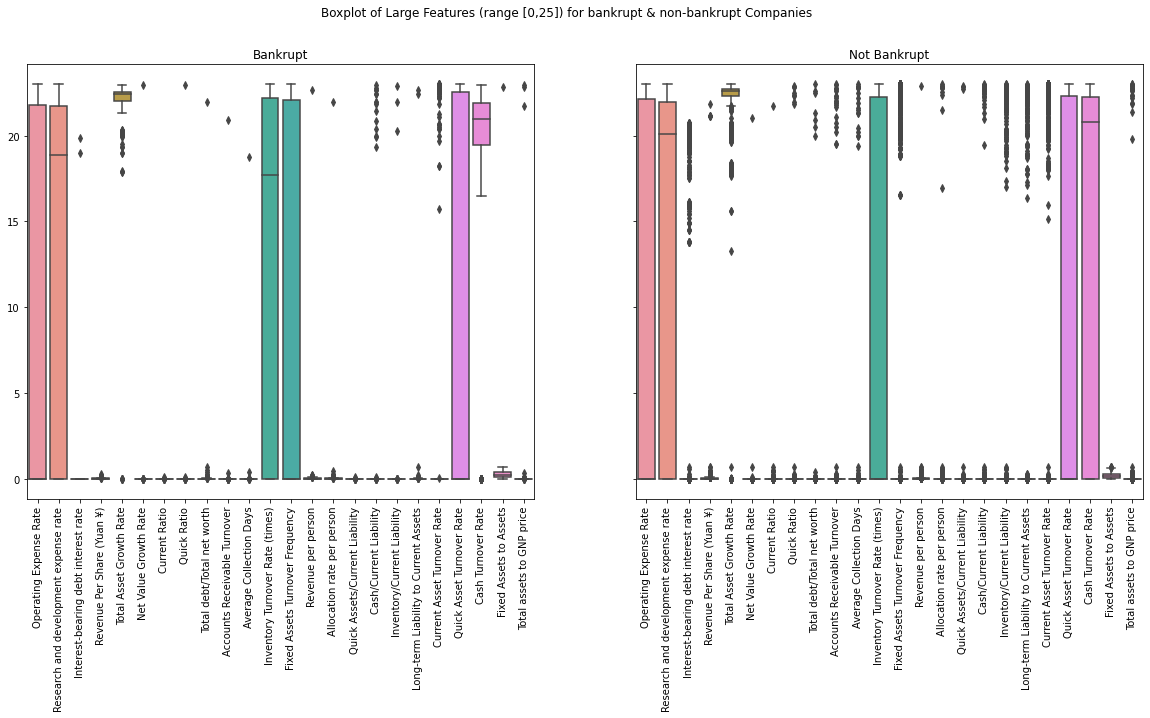

In [17]:
#make boxplot of the large range features, scaled using np.log1p()

boxplot_lrf = large_range_features_log1p
#we can use the same mask as the other boxplot, since we have the same number of rows
boxplot_lrf_bankrupt = boxplot_lrf.loc[(small_range_features['Bankrupt?'] == 1)] 
boxplot_lrf_not_bankrupt = boxplot_lrf.loc[small_range_features['Bankrupt?'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Boxplot of Large Features (range [0,25]) for bankrupt & non-bankrupt Companies')

sns.boxplot(ax=axes[0], data = boxplot_lrf_bankrupt)
axes[0].set_title('Bankrupt')
axes[0].set_xticklabels(boxplot_lrf_bankrupt.columns,rotation=90)

sns.boxplot(ax=axes[1], data = boxplot_lrf_not_bankrupt)
axes[1].set_title('Not Bankrupt');
axes[1].set_xticklabels(boxplot_lrf_not_bankrupt.columns,rotation=90);


From the boxplot visualization, at a quick glance we can see that there appears to be more variability in non-bankrupt companies than in bankrupt companies. We see that for certain features that are clear indicators of successful business (like Return on Assets, Total income, etc.), we see more higher-performing datapoints in the non-bankrupt set than in the bankrupt set.

### 3.4.3 T-Test<a id='3.4.3'></a>

A t-test is a statistical test that is used to compare the means of two groups. We will use the t-test to determine which features are different between our two groups: bankrupt and non-bankrupt companies.

In this case, the null hypothesis is that, for a given feature, there is no difference in the means between the bankrupt and non-bankrupt groups. If we find that the results are significantly different (here we'll define that as p-value < 0.01), then we will define that as significant.

In [18]:
#use scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate', alternative='two-sided')

#split the dataset into bankrupt and non-bankrupt groups
df_bankrupt = df[df['Bankrupt?'] == 1].drop(columns=['Bankrupt?'])
df_not_bankrupt = df[df['Bankrupt?'] == 0].drop(columns=['Bankrupt?'])

ttest_pvalues = [] #make an empty list for pvalues
significance = [] #make an empty list for True/False significance

#iterate over each row and add append the results to our empty lists
for i in range(df_not_bankrupt.shape[1]):
    result = ttest_ind(df_bankrupt.iloc[:,i], df_not_bankrupt.iloc[:,i]).pvalue
    ttest_pvalues.append(result)
    if result < 0.01:
        significance.append(True)
    else:
        significance.append(False)

df_ttest_results = pd.DataFrame(index = df.columns[1:])
df_ttest_results['p_value'] = ttest_pvalues
df_ttest_results['significance'] = significance

In [19]:
#Let's see the results.

#since the defuault number of rows displayed is 10, we need to increase it.
pd.set_option('display.max_rows', df_ttest_results.shape[0]+1)

df_ttest_results

,p_value,significance
ROA(C) before interest and depreciation before interest,1.950813e-106,True
ROA(A) before interest and % after tax,1.033741e-125,True
ROA(B) before interest and depreciation after tax,7.094590e-117,True
Operating Gross Margin,1.225969e-16,True
Realized Sales Gross Margin,1.859407e-16,True
Operating Profit Rate,9.848617e-01,False
Pre-tax net Interest Rate,4.819580e-01,False
After-tax net Interest Rate,4.646049e-01,False
Non-industry income and expenditure/revenue,1.706815e-01,False
Continuous interest rate (after tax),4.882409e-01,False


In [20]:
significant_features = df_ttest_results[df_ttest_results.significance==True].index
not_significant_features = df_ttest_results[df_ttest_results.significance==False].index

print('There are',len(significant_features),'features that are statistically significant between the two groups.')
print('There are',len(not_significant_features),'features that are NOT statistically significant between the two groups.')

There are 56 features that are statistically significant between the two groups.
There are 38 features that are NOT statistically significant between the two groups.


In [21]:
#What are the statistically significant features?
significant_features

Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Cash flow rate', 'Tax rate (A)', 'Net Value Per Share (B)',
       'Net Value Per Share (A)', 'Net Value Per Share (C)',
       'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'After-tax Net Profit Growth Rate', 'Regular Net Profit Growth Rate',
       'Total Asset Growth Rate', 'Net Value Growth Rate',
       'Cash Reinvestment %', 'Debt ratio %', 'Net worth/Assets',
       'Borrowing dependency', 'Contingent liabilities/Net worth',
       'Operating profit/Paid-in capital',
       'Net profit before tax/Paid-in capital',
       'Inventory and accounts receivable/Net value', 'Total Asset Turnover',
       'Fixed Assets Tur

In [22]:
#What about not statistically significant? Do these results make sense?
not_significant_features

Index(['Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate',
       'Interest-bearing debt interest rate', 'Revenue Per Share (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'Continuous Net Profit Growth Rate',
       'Total Asset Return Growth Rate Ratio', 'Current Ratio', 'Quick Ratio',
       'Interest Expense Ratio', 'Total debt/Total net worth',
       'Long-term fund suitability ratio (A)', 'Accounts Receivable Turnover',
       'Average Collection Days', 'Inventory Turnover Rate (times)',
       'Net Worth Turnover Rate (times)', 'Allocation rate per person',
       'Quick Assets/Current Liability', 'Inventory/Working Capital',
       'Inventory/Current Liability', 'Current Liabilities/Liability',
       'Long-term Lia

We found that 56 of our 94 features are statistically significant between the bankrupt and non-bankrupt groups. This means that for these features their distributions/means are different enough (p-value < 0.01) that we reject the null hypothesis that says the two groups are the same. 

If we slowly parse through the list of features, we find that the results make logical sense. ROA (return on assets) will intuitively be higher for non-bankrupt companies than for bankrupt companies. Operating profict, cash flow, etc. many of these features likewise will intuitively be different between the two groups.

Among the list of not-significant features, we see features like non-industry income or research and development expense rate. These again make sense that we don't see a significant difference between groups. How much money a company spends on R&D depends more on the market sector it is in, rather than whether it becomes bankrupt or not. These features can be considered _noise_, and PCA should be able to consolidate it and remove it.

## 3.5 Dimensionality Reduction<a id='3.5'></a>

Earlier we saw that 38 of our 94 features were not statistically significant when we ran a t-test on the different classes. We also saw from the correlation heatmap that not all features are independent of each other. This is a clear indicator to us that our dataset would benefit greatly from dimensionality reduction--this would reduce noise (unimportant features) and remove redundant features (non-independent features), which will improve the performance of our eventual model. 

In this section, we will use PCA and t-SNE for dimensionality reduction and visualization, with labeling from K-Means.

### 3.5.1 Scaling the Data<a id='3.5.1'></a>

In [23]:
#before we can do PCA, we need to scale the data.

#separate the target variable (bankrupt) from the features
y = df['Bankrupt?']
X = df.drop(columns = ['Bankrupt?'])

#Since several of our features are in the trillions, we do a log scale on all our features
X_log = np.log1p(X) #use log1p (ln(1+x)) to avoid log(0) errors

#Now scale everything to be on the same magnitude. We use StandardScaler.
scaler = StandardScaler()
scaler.fit(X_log)
X_scaled = scaler.transform(X_log)

In [24]:
#Verify the scaling. Since we used StandardScaler, the mean should be near 0 and stddev near 1.
print('The mean of the scaled data is:', X_scaled.mean())
print('The std dev of the scaled data is:', X_scaled.std())

#the results are as we expect. Mean is close to zero, and stddev is 1.

The mean of the scaled data is: 1.4193428855969277e-16
The std dev of the scaled data is: 1.0


### 3.5.2 PCA and Scree Plots<a id='3.5.2'></a>

In [25]:
#Fit the PCA to the scaled data.
pca = PCA()
bankruptcy_pca = pca.fit(X_scaled)

In [26]:
# This line of code tells us how many n+1 components we need to explain 85% of the total variance.
(pca.explained_variance_ratio_.cumsum() < 0.85).sum()

#In this case, the result is 36. i.e. the 37th component will result in a cumsum surpassing 85%.

pca.explained_variance_ratio_.cumsum()[36]

0.850759072515257

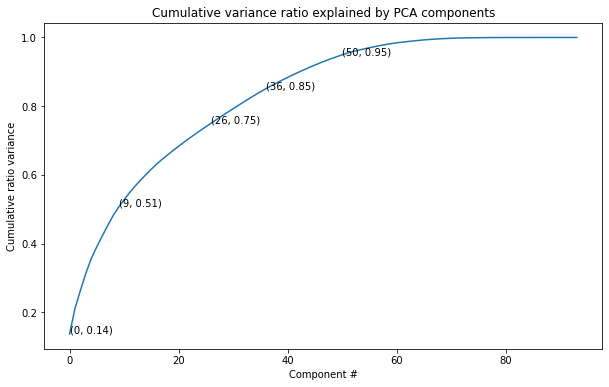

In [27]:
#Plot the cumulative variance ratio with number of components.

_=plt.subplots(figsize=(10,6))
_=plt.plot(bankruptcy_pca.explained_variance_ratio_.cumsum())
_=plt.xlabel('Component #')
_=plt.ylabel('Cumulative ratio variance')
_=plt.title('Cumulative variance ratio explained by PCA components')

#From earlier, we know the first 37 components explain 85% of the variance. Annotate this point.
points_of_interest = [0,9,26,36,50] #pick several point to annotate.
B = []
for i in points_of_interest:
    C = pca.explained_variance_ratio_.cumsum()[i]
    B.append(round(C,2))
A= points_of_interest

for xy in zip(A, B):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

From the cumulative variance graph, we see that the first 10 components contribute to 50% of the variance, the first 27 to 75%, the first 37 to 85%, and the first 51 to 95% (recall that we start with component '0' and not '1').

In some datasets, most of the variance is able to be explained in the first 2-3 PC's, if we're lucky. Unfortunately that is not the case here. We should use a scree plot to further visualize which components to keep.

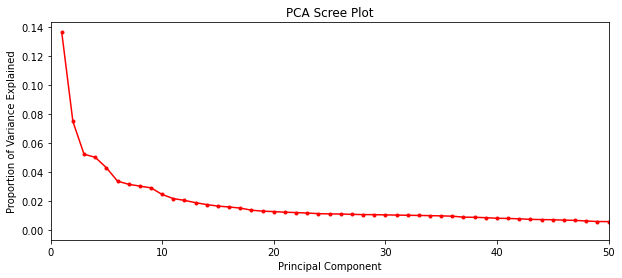

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
y_pca = pca.explained_variance_ratio_
x_pca = np.arange(len(y_pca))+1
plt.plot(x_pca, y_pca, 'r.-')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xlim([0,50]) #image only the first 50 components to save space
plt.show()

In [29]:
#How many PCs have eigenvalues of at least 1?
(pca.explained_variance_ >= 1).sum()

27

We can use the scree plot to determine which components to keep. One possible method is to look for the "elbow" of the graph, when the curve goes from very steep to shallow. We see a couple "elbow" candidates, and PC2, PC5, and PC10.

Other possible methods to determine what PCs to pick are the Kaiser rule (picking PCs with eigenvalues of at least 1) or to select the number of PCs that describe at least 85% of the variance. The Kaiser rule results in selecting the first 27 PCs, and the variance rule results in selecting the first 36 PCs.

In summary on how many PCs to keep:
* Elbow Method: 6 or 11
* Kaiser rule: 27
* 85% Variance: 36
* 95% Variance: 50

From the cumulative variance plot, we know that the first 50 components explain 95% of the variance, and in the scikit-learn documentation for t-SNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE), it is suggested that we can reduce down to 50 components. When we use t-SNE, we'll use the first 50 PCs from PCA.

In [30]:
#Let's see how important (and in what direction) each feature contributes to each principal component.
pd.DataFrame(bankruptcy_pca.components_, columns=df.columns[1:]).head(10).T #just the first 10 rows

,0,1,2,3,4,5,6,7,8,9
ROA(C) before interest and depreciation before interest,-0.235131,0.077953,0.056584,-0.079527,-0.008861,-0.033117,-0.025050,-0.020766,0.003820,-0.022140
ROA(A) before interest and % after tax,-0.234936,0.085634,0.043315,-0.074675,-0.006561,0.007468,-0.024273,-0.010386,0.008389,-0.026690
ROA(B) before interest and depreciation after tax,-0.232579,0.074604,0.063538,-0.081007,-0.010377,-0.027092,-0.025064,-0.020506,0.004810,-0.018254
Operating Gross Margin,-0.114583,-0.028158,0.081737,0.166837,0.036854,-0.214140,-0.337610,0.100933,0.117874,-0.086260
Realized Sales Gross Margin,-0.114196,-0.028442,0.081586,0.167320,0.036946,-0.214526,-0.337484,0.100617,0.117711,-0.086591
Operating Profit Rate,-0.010668,0.017112,-0.036759,0.038568,-0.417708,-0.036874,-0.085788,0.089954,-0.284303,0.040385
Pre-tax net Interest Rate,-0.017430,0.015835,-0.037322,0.055780,-0.479086,-0.014765,-0.050282,0.049545,-0.078749,0.017735
After-tax net Interest Rate,-0.017564,0.013642,-0.036827,0.061667,-0.487065,-0.000844,-0.022088,0.026966,0.029829,0.006089
Non-industry income and expenditure/revenue,-0.011324,-0.009390,0.013318,0.021548,0.030466,0.059355,0.095618,-0.116274,0.522484,-0.062558
Continuous interest rate (after tax),-0.016797,0.015409,-0.036202,0.056722,-0.480880,-0.018524,-0.043212,0.054507,-0.069349,0.019251


Looking at PC0 and PC1 (the first 2 components), we see that the features with the biggest values and their sign (+/-) are: 
* PC 0:
    * ROA (A, B and C) (-)
    * Persistent EPS in the Last Four Seasons (-)
    * Operating Profit Per Share (Yuan ¥) (-)
    * Per Share Net profit before tax (Yuan ¥) (-)
    * Operating profit/Paid-in capital (-)
    * Net profit before tax/Paid-in capital (-)
    * Net Income Total Assets (-)
* PC 1:
    * Debt ratio % (+)
    * Borrowing dependency (+)
    * Inventory and accounts receivable/Net value (+)
    * Net Worth Turnover Rate (times) (+)
    * Current Liability to Assets (+)
    * Current Liabilities/Equity (+)
    * Current Liability to Equity (+)
    * Liability to Equity (+)

Interestingly, the signage is (-) for the highest-contributing features in PC0 and (+) for those in PC1. What this tells us is that the features listed in PC0 likely play a role in decreasing the likelihood of a company going bankrupt (since we defined bankruptcy as '1' and non-bankruptcy as '0'). The features listed in PC1 likely play a role in increaseing the likelihood of bankruptcy.    

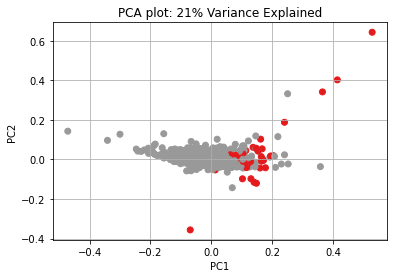

In [32]:
#Let's plot a 2D PCA, using PC0 and PC1 as the x and y axes.

pca = PCA()
x_new = pca.fit_transform(X_scaled)

# fig, ax = plt.subplots(figsize=(8,6))
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = (y), cmap = 'Set1_r')
# plt.xlim(-0.1,0.4)
# plt.ylim(-0.2,0.2)
    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA plot: 21% Variance Explained') #note, if you look at cumsum(), the first 2 PCs explain only 21%
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

Since we did see an elbow at PC2, let's plot a 3D plot of the first 3 PCs (PC0, PC1, and PC2).

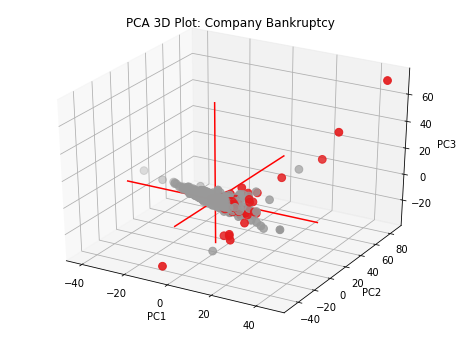

In [33]:
#plot the PCA along the first 3 PCs.
#Code adapted from: https://www.python-graph-gallery.com/372-3d-pca-result

# Run The PCA
pca3d = PCA(n_components=3)
pca3d.fit(X_scaled)
    
# Store results of PCA in a data frame
result=pd.DataFrame(pca3d.transform(X_scaled), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=y, cmap="Set1_r", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D Plot: Company Bankruptcy")
plt.show()

Unsuprisingly, the 3D PCA plot looks strikingly similar to that of the 2D plot. 

We are still lacking good separation. t-SNE is another method we can try to better separate (and visualize) our data.

### 3.5.3 Visualizing with t-SNE<a id='3.5.3'></a>

t-distributed Stochastic Neighbor Embedding (t-SNE) is a tool to visualize high-dimensional data. It has several advantages over other manifold learning techniques, as it is particularly sensitive to local structure. We can use t-SNE to visualize our data and check whether we achieve good separation between our classes (though poor separation in t-SNE may also indicate that 2 dimensions is insufficient in representing the internal strucutre of the data). 

t-SNE is often used in combination with PCA or other dimensionality reduction methods to reduce the number of dimensions to a reasonable amount (the sklearn documentation gives an example of 50, so we will use that here). This will suppress some noise and speed up the computation of pairwise distances between samples. 

The following code is adapted from the following:
* https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

In [34]:
#reduce to 50 components
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(X_scaled)
print('The explained variance of the first 50 PCs:', round(pca_50.explained_variance_ratio_.cumsum()[-1]*100,2),'%')

The explained variance of the first 50 PCs: 94.41 %


In [35]:
#check if our 94 features was really reduced to 50
pca_result_50.shape

(6819, 50)

In [36]:
time_start = time.time()
tsne = TSNE(n_components=2, init='random',
                         random_state=42, perplexity=100)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('Time: {} seconds'.format(time.time()-time_start))

Time: 58.038124322891235 seconds


In [37]:
#make the tSNE results into a dataframe.
df_tsne_pca_results = pd.DataFrame(tsne_pca_results, columns=['tSNE%i' % i for i in range(2)], index=df.index)
df_tsne_pca_results['y'] = y

#Do the same for our PCA results. This will allow us to plot and compare.
df_pca_result_50 = pd.DataFrame(pca_result_50, columns=['PCA%i' % i for i in range(50)], index=df.index)
df_pca_result_50['y'] = y

perplexity=5 in 27 sec
perplexity=30 in 35 sec
perplexity=50 in 43 sec
perplexity=80 in 52 sec
perplexity=100 in 58 sec


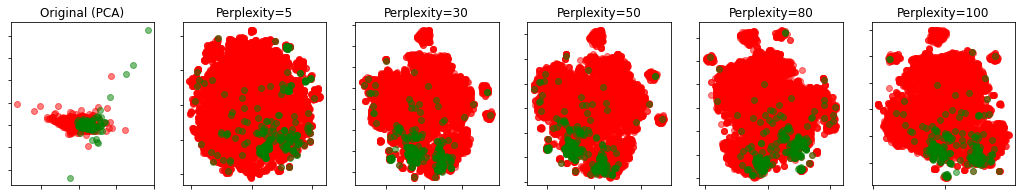

In [38]:
# The following code is adapted from the scikit-learn t-SNE documentation. Author: Narine Kokhlikyan <narine@slice.com>
# https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

n_components = 2
(fig, subplots) = plt.subplots(1, 6, figsize=(18, 3), squeeze=False)
perplexities = [5, 30, 50, 80, 100] #Note: sometimes N^(1/2) is used to select perplexity. Here, sqrt(N=6819) is approx ~80.

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.set_title("Original (PCA)")
ax.scatter(pca_result_50[red, 0], pca_result_50[red, 1], c="r", alpha=0.5)
ax.scatter(pca_result_50[green, 0], pca_result_50[green, 1], c="g", alpha=0.5)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i + 1]

    t0 = time.time()
    tsne = TSNE(n_components=n_components, init='random',
                         random_state=42, perplexity=perplexity, n_jobs=-1)
    Y = tsne.fit_transform(pca_result_50)
    t1 = time.time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r", alpha=0.5)
    ax.scatter(Y[green, 0], Y[green, 1], c="g", alpha=0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

From the series of plots, we see that increased perplexity results in clearer clustering. The green dots, representing the minority class (bankrupt companies) is clustered better with higher perplexity. This is most apparent when we compare perplexity=5 to a higher number like perplexity=80 or 100. There is a general rule-of-thumb when selecting perplexity to choose N^(1/2). Since we have N=6819, N^(1/2) ~ 82.6; we can see that the results for perplexity fo 80 is quite similar to that of perplexity of 100. Going forward, we select perplexity=80 as our optimal parameter.

Unfortunately there isn't a clear separation between our classes, and we still see significant overlap. We may want to consider looking into modifying other t-SNE hyperparameters.

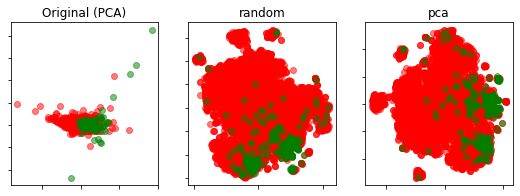

In [39]:
#Let's compare other parameters: init, learning_rate, angle
    # init{‘random’, ‘pca’}, 
    # learning_rate, default=200. The learning rate for t-SNE is usually in the range [10.0, 1000.0]
    # angle, default=0.5. This method is not very sensitive to changes in this parameter in the range of 0.2 - 0.8. 
        # Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error.

#Compare init{‘random’, ‘pca’}
initializations = ['random', 'pca']

n_components = 2
perplexity = 80 #from earlier, use perplexity = 80
(fig, subplots) = plt.subplots(1, 3, figsize=(9, 3), squeeze=False)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.set_title("Original (PCA)")
ax.scatter(pca_result_50[red, 0], pca_result_50[red, 1], c="r", alpha=0.5)
ax.scatter(pca_result_50[green, 0], pca_result_50[green, 1], c="g", alpha=0.5)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, init in enumerate(initializations):
    ax = subplots[0][i + 1]

    t0 = time.time()
    tsne = TSNE(n_components=n_components, init=init,
                         random_state=42, perplexity=perplexity, n_jobs=-1)
    Y = tsne.fit_transform(pca_result_50)
    t1 = time.time()
#     print("init=%d in %.2g sec" % (init, t1 - t0))
    ax.set_title(init)
    ax.scatter(Y[red, 0], Y[red, 1], c="r", alpha=0.5)
    ax.scatter(Y[green, 0], Y[green, 1], c="g", alpha=0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

From the plots, we see that there is more spread with 'random' initialization, but overall the plots are very similar (they almost look like rotations of each other). We will stick with init='random', as that is the default.

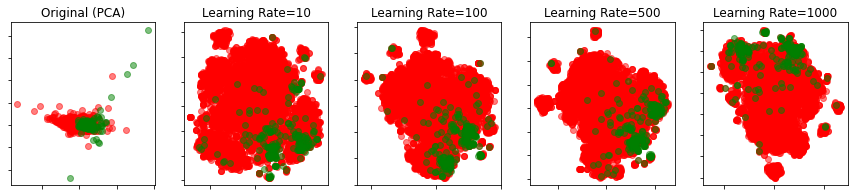

In [40]:
#Let's compare other parameters: init, learning_rate, angle
    # init{‘random’, ‘pca’}, 
    # learning_rate, default=200. The learning rate for t-SNE is usually in the range [10.0, 1000.0]
    # angle, default=0.5. This method is not very sensitive to changes in this parameter in the range of 0.2 - 0.8. 
        # Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error.

#Compare learning_rate
learning_rate = [10, 100, 500, 1000]


n_components = 2
perplexity = 80 #from earlier, use perplexity = 80
init = 'random' #from earlier, use init = 'random'
(fig, subplots) = plt.subplots(1, 5, figsize=(15, 3), squeeze=False)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.set_title("Original (PCA)")
ax.scatter(pca_result_50[red, 0], pca_result_50[red, 1], c="r", alpha=0.5)
ax.scatter(pca_result_50[green, 0], pca_result_50[green, 1], c="g", alpha=0.5)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, lr in enumerate(learning_rate):
    ax = subplots[0][i + 1]

    t0 = time.time()
    tsne = TSNE(n_components=n_components, init=init, learning_rate=lr, 
                         random_state=42, perplexity=perplexity, n_jobs=-1)
    Y = tsne.fit_transform(pca_result_50)
    t1 = time.time()
    ax.set_title("Learning Rate="+ str(lr))
    ax.scatter(Y[red, 0], Y[red, 1], c="r", alpha=0.5)
    ax.scatter(Y[green, 0], Y[green, 1], c="g", alpha=0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

When selecting the learning rate for t-SNE, a learning rate that is too low may result in a compressed dense cloud with few outliers while a learning rate that is too high may result in a 'ball' where any point is equipdistant from its nearest neighbors. The default is 200, and we want to avoid picking a value that is too big or too small.

There does not appear to be much improvement between learning rates 100, 200, 500, and 1000. With learning_rate=500, the green dots appear to be clustered more closely together, and we do not see as many stray dots spread across the red. We will continue with learning_rate=500.

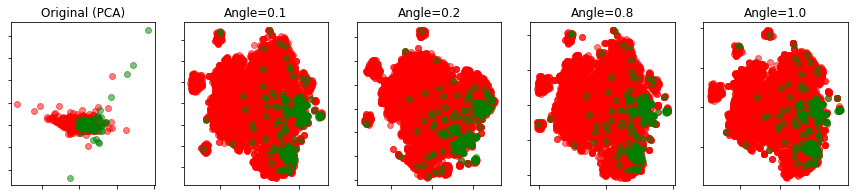

In [59]:
#Let's compare other parameters: init, learning_rate, angle
    # init{‘random’, ‘pca’}, 
    # learning_rate, default=200. The learning rate for t-SNE is usually in the range [10.0, 1000.0]
    # angle, default=0.5. This method is not very sensitive to changes in this parameter in the range of 0.2 - 0.8. 
        # Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error.

#Compare angle
angles = [0.1, 0.2, 0.8, 1.0] #we focus on the edge cases, since 0.2-0.8 does not vary much


n_components = 2
perplexity = 80 #from earlier, use perplexity = 80
init = 'random' #from earlier, use init = 'random'
learning_rate = 500 #from earlier, use learning_rate = 500
(fig, subplots) = plt.subplots(1, 5, figsize=(15, 3), squeeze=False)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.set_title("Original (PCA)")
ax.scatter(pca_result_50[red, 0], pca_result_50[red, 1], c="r", alpha=0.5)
ax.scatter(pca_result_50[green, 0], pca_result_50[green, 1], c="g", alpha=0.5)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, angle in enumerate(angles):
    ax = subplots[0][i + 1]

    t0 = time.time()
    tsne = TSNE(n_components=n_components, init=init, learning_rate=learning_rate, 
                 angle=angle, random_state=42, perplexity=perplexity, n_jobs=-1)
    Y = tsne.fit_transform(pca_result_50)
    t1 = time.time()
    ax.set_title("Angle="+ str(angle))
    ax.scatter(Y[red, 0], Y[red, 1], c="r", alpha=0.5)
    ax.scatter(Y[green, 0], Y[green, 1], c="g", alpha=0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

From these plots, we see angle=0.1 and 0.8 produces plots with the majority of the green dots gathered to one side, whereas the other angles have a broader spread. We will continue with angle=0.1.

Now that we have selected our parameters, we can visualize with t-SNE once again with our tuned parameters: perplexity = 80, init = 'random', learning_rate = 500, angle = 0.1

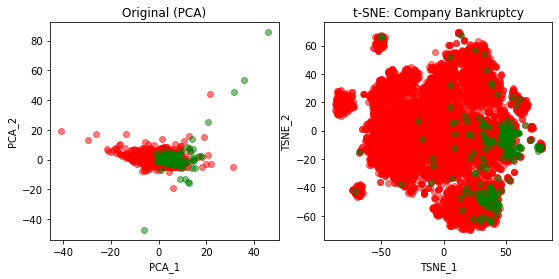

In [61]:
n_components = 2
perplexity = 80
init = 'random'
learning_rate = 500 
angle = 0.1
(fig, subplots) = plt.subplots(1, 2, figsize=(9, 4), squeeze=False)

red = y == 0
green = y == 1

ax = subplots[0][0]
ax.set_title("Original (PCA)")
ax.scatter(pca_result_50[red, 0], pca_result_50[red, 1], c="r", alpha=0.5)
ax.scatter(pca_result_50[green, 0], pca_result_50[green, 1], c="g", alpha=0.5)
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
plt.axis('tight')

ax = subplots[0][1]
tsne = TSNE(n_components=n_components, init=init, learning_rate=learning_rate, 
             angle=angle, random_state=42, perplexity=perplexity, n_jobs=-1)
Y = tsne.fit_transform(pca_result_50)
ax.set_title('t-SNE: Company Bankruptcy')
ax.scatter(Y[red, 0], Y[red, 1], c="r", alpha=0.5)
ax.scatter(Y[green, 0], Y[green, 1], c="g", alpha=0.5)
ax.set_xlabel('TSNE_1')
ax.set_ylabel('TSNE_2')
ax.axis('tight')

plt.show()

### 3.5.3.1 K-Means Clustering<a id='3.5.3.1'></a>

As stated in the intro, we can use K-Means Clustering to enhance out visualization. K-Means is an unsupervised learning method, and may be able to show us whether there are underlying similarities in the company data. In combination with t-SNE, we may be able to identify patterns in the data and see wether bankrupt companies predominantly fall under a given cluster label.

Below, we will conduct K-Means Clustering on the scaled data, the PCA-reduced data, and the tSNE-reduced data.

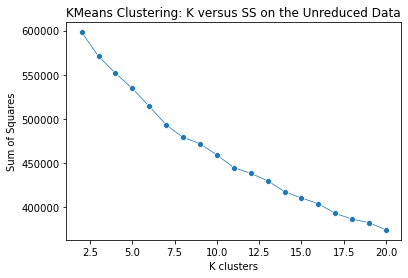

In [43]:
#Plot the KMeans inertia against n_components, and use the elbow method to select number of clusters.
#Here we run KMeans against the scaled data (i.e. no dimensionality reduction)

x_ss = []
y_ss = []

for n in range(2,21):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X_scaled)
    x_ss.append(n)
    y_ss.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.

_=plt.xlabel('K clusters')
_=plt.ylabel('Sum of Squares')
_=plt.title('KMeans Clustering: K versus SS on the Unreduced Data')
_=sns.lineplot(x_ss,y_ss, marker='o', size=100, legend=False)

#looking at the graph below, the elbow appears to occus at K=8

[0, 1, 2, 3, 4, 5, 6, 7]
[545, 6, 2214, 610, 1, 1690, 1752, 1]


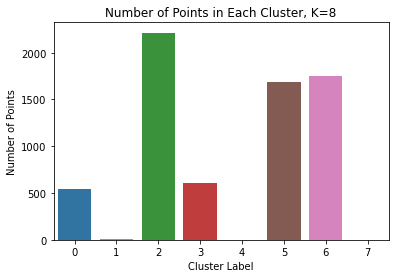

In [44]:
# Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .

kmeans = KMeans(n_clusters=8, random_state=42).fit(X_scaled) #from before, use K=8 as best K.
array = kmeans.labels_ #everything is sorted into one of the 8 clusters

x_points = []
y_points = []

for i in range(8):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

_=plt.xlabel('Cluster Label')
_=plt.ylabel('Number of Points')
_=plt.title('Number of Points in Each Cluster, K=8')
_=sns.barplot(x_points, y_points)

print(x_points)
print(y_points)

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 4, 59, 119, 0, 4, 34, 0]


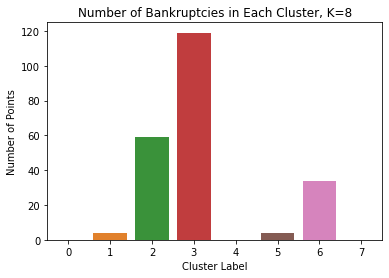

In [45]:
df_klabels = df #make a copy of df
df_klabels['labels'] = kmeans.labels_ #append the cluster labels to df

#find how many of the bankrupt data matches each label
df_bankrupt = df_klabels[df_klabels['Bankrupt?'] == 1] #make subset df containing only bankrupt comapnies

x_points_bankrupt = []
y_points_bankrupt = []

for i in range(8):
    x_points_bankrupt.append(i)
    y_points_bankrupt.append(np.count_nonzero(df_bankrupt.labels == i))

_=plt.xlabel('Cluster Label')
_=plt.ylabel('Number of Points')
_=plt.title('Number of Bankruptcies in Each Cluster, K=8')
_=sns.barplot(x_points_bankrupt, y_points_bankrupt)

print(x_points_bankrupt)
print(y_points_bankrupt)

In [46]:
#What percent of each label is in the bankrupt class?

for i in x_points:
    if y_points[i] == 0:
         print('Label:', i, ', Percent Bankrupt: 0%')
    else:
        print('Label:', i, ', Percent Bankrupt:', round(y_points_bankrupt[i]/y_points[i]*100,2), '%')

Label: 0 , Percent Bankrupt: 0.0 %
Label: 1 , Percent Bankrupt: 66.67 %
Label: 2 , Percent Bankrupt: 2.66 %
Label: 3 , Percent Bankrupt: 19.51 %
Label: 4 , Percent Bankrupt: 0.0 %
Label: 5 , Percent Bankrupt: 0.24 %
Label: 6 , Percent Bankrupt: 1.94 %
Label: 7 , Percent Bankrupt: 0.0 %


We can see that labels 2, 3, and 6 have the most bankrupt companies.

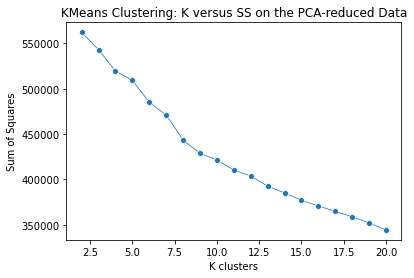

In [47]:
#elbow method for PCA_50

x_ss = []
y_ss = []

for n in range(2,21):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(pca_result_50)
    x_ss.append(n)
    y_ss.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.

_=plt.xlabel('K clusters')
_=plt.ylabel('Sum of Squares')
_=plt.title('KMeans Clustering: K versus SS on the PCA-reduced Data')
_=sns.lineplot(x_ss,y_ss, marker='o', size=100, legend=False)

Even with PCA_50, again the elbow appears at K=8 (slightly more prominently this time)

In [48]:
#Calculate the number of data points and bankrupt points in each cluster

n_clusters = 8

kmeans = KMeans(n_clusters=8, random_state=42).fit(pca_result_50)
array = kmeans.labels_
x_points = []
y_points = []
for i in range(n_clusters):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

    
df_klabels = df #make a copy of df
df_klabels['labels'] = kmeans.labels_ #append the cluster labels to df

#find how many of the bankrupt data matches each label
df_bankrupt = df_klabels[df_klabels['Bankrupt?'] == 1] #make subset df containing only bankrupt comapnies
x_points_bankrupt = []
y_points_bankrupt = []
for i in range(n_clusters):
    x_points_bankrupt.append(i)
    y_points_bankrupt.append(np.count_nonzero(df_bankrupt.labels == i))


print(x_points)
print(y_points)
print(y_points_bankrupt)


#What percent of each label is in the bankrupt class?
for i in x_points:
    if y_points[i] == 0:
         print('Label:', i, ', Percent Bankrupt: 0%')
    else:
        print('Label:', i, ', Percent Bankrupt:', round(y_points_bankrupt[i]/y_points[i]*100,2), '%')

[0, 1, 2, 3, 4, 5, 6, 7]
[543, 683, 2267, 1703, 6, 1, 1615, 1]
[0, 133, 47, 32, 4, 0, 4, 0]
Label: 0 , Percent Bankrupt: 0.0 %
Label: 1 , Percent Bankrupt: 19.47 %
Label: 2 , Percent Bankrupt: 2.07 %
Label: 3 , Percent Bankrupt: 1.88 %
Label: 4 , Percent Bankrupt: 66.67 %
Label: 5 , Percent Bankrupt: 0.0 %
Label: 6 , Percent Bankrupt: 0.25 %
Label: 7 , Percent Bankrupt: 0.0 %


From the PCA-reduced data, we can see that labels 1, 2, and 3 have the most bankrupt companies.

In [62]:
#do the above (K-means with labels, etc.) but this time after t-SNE is processed

n_components = 2
perplexity = 80
init = 'random'
learning_rate = 500 
angle = 0.1

tsne_2 = TSNE(n_components=n_components, init=init, learning_rate=learning_rate, 
                     angle=angle, random_state=42, perplexity=perplexity, n_jobs=-1)
tsne_result_2 = tsne_2.fit_transform(pca_result_50)


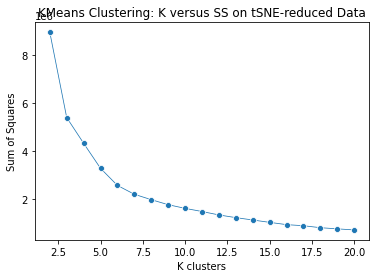

In [63]:
#elbow method for tsne_2

x_ss = []
y_ss = []

for n in range(2,21):
    kmeans = KMeans(n_clusters=n, random_state=42).fit(tsne_result_2)
    x_ss.append(n)
    y_ss.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.

_=plt.xlabel('K clusters')
_=plt.ylabel('Sum of Squares')
_=plt.title('KMeans Clustering: K versus SS on tSNE-reduced Data')
_=sns.lineplot(x_ss,y_ss, marker='o', size=100, legend=False)

From the elbow method, the elbow appears to occur at K=6 clusters. We can verify this result with the silhouette score.

In [64]:
#Silhouette score, on tSNE processed data
cluster = []
score = []

range_n_clusters = np.arange(2,10) #Let's try again with a larger range, and find the max silhouette score.
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(tsne_result_2)
    silhouette_avg = silhouette_score(tsne_result_2, cluster_labels)
    cluster.append(n_clusters)
    score.append(silhouette_avg)

max_score = max(score)
max_score_index = score.index(max_score)
max_score_cluster = cluster[max_score_index]
print("The max silhouette score for the tSNE-transformed data is: ", max_score, " with n_clusters: ", max_score_cluster)


The max silhouette score for the tSNE-transformed data is:  0.41170737  with n_clusters:  6


A silhouette score between 0.26-0.5 is weak and may be artificial, but it matches with what we saw in the elbow method. So we will proceed with 6 clusters.

In [65]:
#using tsne_2, and k=6 clusters, find the % labels

n_clusters = 6

kmeans = KMeans(n_clusters=6, random_state=42).fit(tsne_result_2) 
array = kmeans.labels_
x_points = []
y_points = []
for i in range(n_clusters):
    x_points.append(i)
    y_points.append(np.count_nonzero(array == i))

    
df_klabels = df #make a copy of df
df_klabels['labels'] = kmeans.labels_ #append the cluster labels to df

#find how many of the bankrupt data matches each label
df_bankrupt = df_klabels[df_klabels['Bankrupt?'] == 1] #make subset df containing only bankrupt comapnies
x_points_bankrupt = []
y_points_bankrupt = []
for i in range(n_clusters):
    x_points_bankrupt.append(i)
    y_points_bankrupt.append(np.count_nonzero(df_bankrupt.labels == i))


print(x_points)
print(y_points)
print(y_points_bankrupt)


#What percent of each label is in the bankrupt class?
for i in x_points:
    if y_points[i] == 0:
         print('Label:', i, ', Percent Bankrupt: 0%')
    else:
        print('Label:', i, ', Percent Bankrupt:', round(y_points_bankrupt[i]/y_points[i]*100,2), '%')

[0, 1, 2, 3, 4, 5]
[1133, 1005, 1185, 1192, 962, 1342]
[3, 122, 9, 72, 2, 12]
Label: 0 , Percent Bankrupt: 0.26 %
Label: 1 , Percent Bankrupt: 12.14 %
Label: 2 , Percent Bankrupt: 0.76 %
Label: 3 , Percent Bankrupt: 6.04 %
Label: 4 , Percent Bankrupt: 0.21 %
Label: 5 , Percent Bankrupt: 0.89 %


For the tSNE-reduced data, most of the bankruptcies occur in labels 1 and 3.

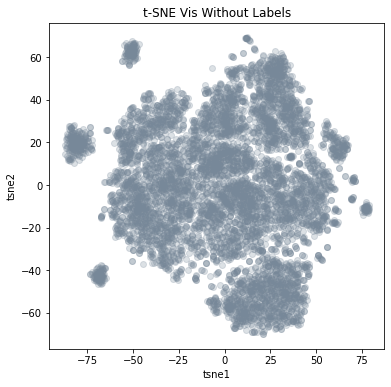

In [66]:
#Plot the tSNE, without labels
tsne_df_scale = pd.DataFrame(tsne_result_2, columns=['tsne1', 'tsne2'])
plt.figure(figsize = (6,6))
plt.scatter(tsne_df_scale.iloc[:,0],tsne_df_scale.iloc[:,1],alpha=0.25, facecolor='lightslategray')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.title('t-SNE Vis Without Labels')
plt.show()

In [67]:
# plot our tsne graph with the 6 cluster labels from tsne_2

kmeans_tsne_scale = KMeans(n_clusters=6, random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.4117073714733124


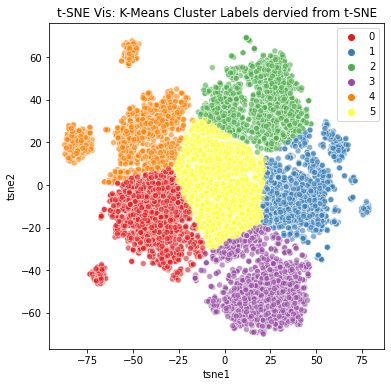

In [68]:
plt.figure(figsize = (6,6))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],
                hue=labels_tsne_scale, palette='Set1', alpha=0.6).set_title('t-SNE Vis: K-Means Cluster Labels dervied from t-SNE')
plt.legend()
plt.show()

In [69]:
# plot our tsne graph with the 8 cluster labels from pca_50

kmeans_pca_scale = KMeans(n_clusters=8, random_state=42).fit(pca_result_50)
print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(pca_result_50, kmeans_pca_scale.labels_, metric='euclidean')))
labels_pca_scale = kmeans_pca_scale.labels_
clusters_pca_scale = pd.concat([tsne_df_scale, pd.DataFrame({'pca_clusters':labels_tsne_scale})], axis=1)


KMeans PCA Scaled Silhouette Score: 0.07793171986326648


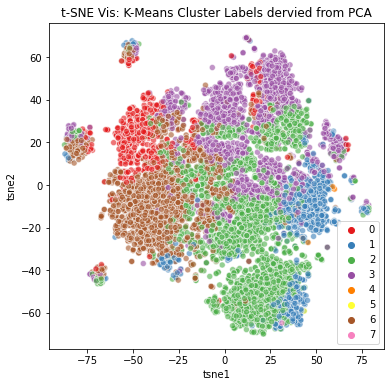

In [70]:
plt.figure(figsize = (6,6))
sns.scatterplot(clusters_pca_scale.iloc[:,0],clusters_pca_scale.iloc[:,1],
                hue=labels_pca_scale, palette='Set1', alpha=0.6).set_title('t-SNE Vis: K-Means Cluster Labels dervied from PCA')
plt.legend()
plt.show()

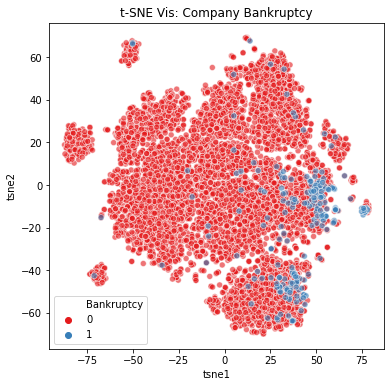

In [71]:
#plot just bankruptcy data
#reorg the data so that the minority class is plotted last (i.e. easier to see visually)

clusters_bankruptcy = pd.concat([tsne_df_scale, pd.DataFrame({'Bankruptcy':y})], axis=1)
clusters_bankruptcy_sorted = clusters_bankruptcy.sort_values(by=['Bankruptcy'])

plt.figure(figsize = (6,6))
sns.scatterplot(clusters_bankruptcy_sorted.iloc[:,0],clusters_bankruptcy_sorted.iloc[:,1],
                hue=clusters_bankruptcy_sorted.Bankruptcy, palette='Set1', alpha=0.6).set_title('t-SNE Vis: Company Bankruptcy')
plt.legend()
plt.show()

## 3.6 Summary and Next Steps<a id='3.6'></a>

__Summary of the Notebook:__

In this Exploratory Data Analysis notebook, we learned the following about our data:
* Correlation Heatmaps 
    * There is no feature with a particularly strong positive correlation to bankruptcy.
    * We did see that 'Debt ratio %' and 'Current Liability to Assets' both have a slight positive correlation with bankruptcy. This makes sense, as companies with larger debts and more liabilities than assets are also more likely to go bankrupt.
    * We also saw that various features, such as 'ROA (Return on Assets)', 'Persistent EPS (earnings per share) in the Last Four Seasons', 'Net worth/Assets', and others all had slight negative correlations with bankruptcy status. This again makes intuitive sense, as these features are signs of a healthy company (i.e. less likely to go bankrupt). If a company has good return on assets, that means they are growing as a company. Persistent earnings per share indicates that their stocks are stable/healthy. Large assets and profit again indicates a healthy company.
    * We saw that there was strong correlations between certain features, indicating that not all of these features are independent, and we would benefit from dimension reduction with PCA.

* Histograms
    * From the histograms, we saw that while many features appear to have a normal distribution, there are others which are highly skewed, such as Tax Rate, Total Asset Turnover, Cash/Total Assets, Current Liability to Assets, Current Liabilities/Liability, Current Liability to Liability, and Equity to Liability. Other features appear to predominantly be in a single bin. We did not see anything that appeared multimodal.

* Boxplots
    * From the boxplot visualization, we saw more variability in non-bankrupt companies than in bankrupt companies. We saw that for certain features that are clear indicators of successful business (like Return on Assets, Total income, etc.), we saw more higher-performing datapoints in the non-bankrupt set than in the bankrupt set.

* T-Tests to determine statistical significance between classes.
    * There are 56 features that are statistically significant between the two groups.
    * There are 38 features that are NOT statistically significant between the two groups. This means that for these features their distributions/means are different enough (p-value < 0.01) that we reject the null hypothesis that says the two groups are the same. Again this indicates that we would benefit from dimension reduction with PCA.

* PCA, t-SNE, and K-Means for dimensionality reduction and visualization.
    * With PCA, we saw that the first 10 components contributed to 50% of the variance, the first 27 to 75%, the first 37 to 85%, and the first 51 to 95%.
        * The Features that contributed the most to the first two principal components were:
        * First Principal Component:
            * ROA (A, B and C) (-)
            * Persistent EPS in the Last Four Seasons (-)
            * Operating Profit Per Share (Yuan ¥) (-)
            * Per Share Net profit before tax (Yuan ¥) (-)
            * Operating profit/Paid-in capital (-)
            * Net profit before tax/Paid-in capital (-)
            * Net Income Total Assets (-)
        * Second Principal Component:
            * Debt ratio % (+)
            * Borrowing dependency (+)
            * Inventory and accounts receivable/Net value (+)
            * Net Worth Turnover Rate (times) (+)
            * Current Liability to Assets (+)
            * Current Liabilities/Equity (+)
            * Current Liability to Equity (+)
            * Liability to Equity (+)
        * The signage is (-) for the highest-contributing features in the first PC and (+) for those in the second PC. What this tells us is that the features listed in the first PC decrease the likelihood of a company going bankrupt (since we defined bankruptcy as '1' and non-bankruptcy as '0'). The features listed in the second PC increase the likelihood of bankruptcy.
    * We used the first 50 PCs to derive labels with K-Means clustering (n_clusters=8) and plot that on the t-SNE.
    * We optimized t-SNE for the best looking t-SNE visual, using n_components=2. Our tuned parameters were: 
        * perplexity = 80
        * init = 'random'
        * learning_rate = 500 
        * angle = 0.1
        * Note that when optimizing t-SNE, results will differ very much with different initializations. We used random_state=42, but any other number would lead to a different result, with different optimal paramters.
    * We used t-SNE to reduce the 50 PCs down to 2 components, and derived labels with K-Means clustering (n_culsters=6) and plot that on the t-SNE.

__The K-Means labels on PCA (94 features reduced to 50 features):__

|Label|Points (total=6819)|Bankrupt Points (total=220)|Percent Bankrupt|
|:--|--:|--:|--:|
|0|543|0|0.00%|
|1|683|133|19.47%|
|2|2267|47|2.07%|
|3|1703|32|1.88%|
|4|6|4|66.67%|
|5|1|0|0.00%|
|6|1615|4|0.25%|
|7|1|0|0.00%|

__Next Steps:__

The K-Means labels on the PCA-reduced features can be utilized as an additional feature. In our next notebook, "Preprocessing and Training Data Development", we will conduct a train/test split, scale and process the training data in the same way we did in this notebook, and then use SMOTE to upsample our minority class. This would result in a processed dataset suitable for training our classification models.